In [1]:
# https://blog.naver.com/chromatic_365/222657670527
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pymysql
import matplotlib as mpl

# mysql db 연동
db = pymysql.connect(host='127.0.0.1',password='gkftndlTek!!',user='root',db='tp',charset='utf8', 
    cursorclass=pymysql.cursors.DictCursor)

cursor = db.cursor()

query = "select FM,PU1,PU2,TE1,TE2,TE3,P1,P2,P3,P4 from wholeData where DATETIME between '2014-05-01 00:00:00' and '2014-08-31 23:00:00'"
cursor.execute(query)
db_export = cursor.fetchall()

tp=pd.DataFrame(db_export)
#db_result_df = db_result_df.drop([db_result_df.columns[0]], axis=1) # 중복 index열 삭제

# scaling
def standard_scaling(df, scale_columns):
    for col in scale_columns:
        series_mean = df[col].mean()
        series_std = df[col].std()
        df[col] = df[col].apply(lambda x: (x-series_mean)/series_std)
    return df

scale_columns = ['FM', 'PU1', 'PU2', 'TE1', 'TE2', 'TE3', 'P1', 'P2', 'P3','P4']
tp_df = standard_scaling(tp, scale_columns)

tp_df_corr=tp_df.corr()
tp_df_corr

#https://blog.naver.com/moongda0404/222729519749
# 대학본부의 2014, 2015 데이터로 2016 FM 예측

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

#학습 데이터와 테스트 데이터로 분리
#'FM'을 제외한 모든 칼럼들은 X
X=tp[tp.columns.difference(['FM'])]

y=tp['FM']


from sklearn.linear_model import LinearRegression

X = X.apply(pd.to_numeric, errors='coerce')
y = y.apply(pd.to_numeric, errors='coerce')

X.fillna(0, inplace=True)
y.fillna(0, inplace=True)

#검증(test)는 20%로 한다. =test_siz=0.2
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2,random_state=19)

#회귀 분석 객체 생성(선형 회귀 모델 생성)
lr=linear_model.LinearRegression()

#fit()는 기울기와 절편을 전달하기 위함
model=lr.fit(X_train, y_train)

#새로운 값 예측
x_new=X_test
y_new=model.predict(x_new)

print(type(y_test))

y_compare={'y_test':y_test,'y_predicted':y_new}
pd.DataFrame(y_compare)

print("\n")
#https://blog.naver.com/moongda0404/222729524245

# train R2 score를 출력
print(model.score(X_train, y_train))

# test R2 score를 출력
print(model.score(X_test, y_test))

<class 'pandas.core.series.Series'>


0.7509000209973994
0.7159992531269681


<AxesSubplot:>

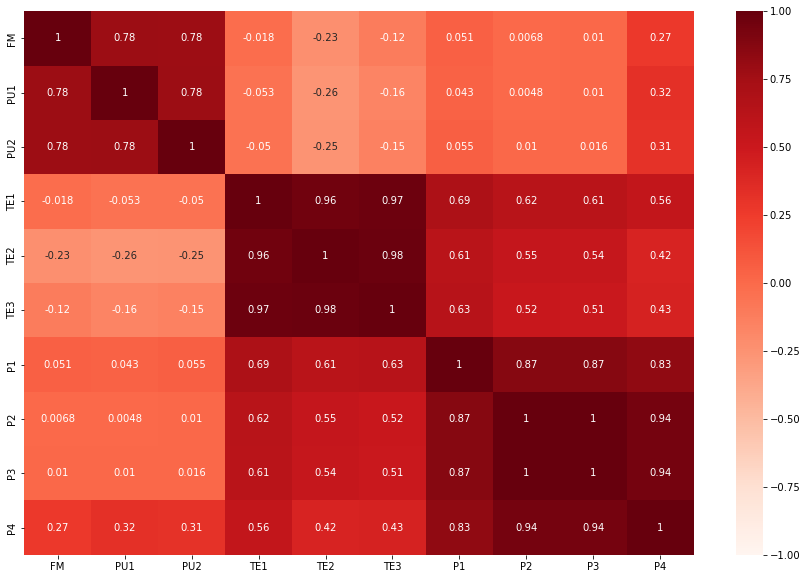

In [4]:
import seaborn as sb
tp_corr=tp[['FM', 'PU1', 'PU2', 'TE1', 'TE2', 'TE3', 'P1', 'P2', 'P3','P4']]
plt.rcParams['figure.figsize']=(15,10)

sb.heatmap(tp_corr.corr(),
          annot=True,
          cmap='Reds',
          vmin=-1,vmax=1
          )

In [5]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# 피처마다의 VIF 계수를 출력한다.
vif=pd.DataFrame()
vif["VIF Factor"]=[variance_inflation_factor(tp_corr.values,i) for i in range(tp_corr.shape[1])]
vif["features"]=tp_corr.columns
vif

,VIF Factor,features
0,3.939558,FM
1,10.604553,PU1
2,7.599886,PU2
3,48.192996,TE1
4,63.532254,TE2
5,63.919800,TE3
6,5.573430,P1
7,864.390399,P2
8,897.846912,P3
9,168.616286,P4


In [6]:
tp_corr=tp_corr.drop(['TE3','P3'], axis=1)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(tp_corr.values, i) for i in range(tp_corr.shape[1])]
vif["features"] = tp_corr.columns
vif

,VIF Factor,features
0,3.860115,FM
1,9.994285,PU1
2,7.030598,PU2
3,38.590615,TE1
4,36.985278,TE2
5,4.907285,P1
6,132.859199,P2
7,146.830416,P4


In [7]:
tp_corr=tp_corr.drop(['TE1','P4'], axis=1)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(tp_corr.values, i) for i in range(tp_corr.shape[1])]
vif["features"] = tp_corr.columns
vif

,VIF Factor,features
0,3.158568,FM
1,3.300474,PU1
2,3.176602,PU2
3,1.876772,TE2
4,4.826402,P1
5,4.096994,P2


In [8]:
vif.features.values

array(['FM', 'PU1', 'PU2', 'TE2', 'P1', 'P2'], dtype=object)

In [9]:
tp_corr_re=tp_corr[['FM', 'PU1', 'PU2', 'TE2','P1','P2']]

X=tp_corr_re[tp_corr_re.columns.difference(['FM'])]
y=tp_corr_re['FM']

X_trian,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, random_state=19)

lr=linear_model.LinearRegression()
model=lr.fit(X_trian,y_train)

In [11]:
import statsmodels.api as sm

X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     FM   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     778.1
Date:                Wed, 31 Aug 2022   Prob (F-statistic):               0.00
Time:                        17:59:18   Log-Likelihood:                -1752.5
No. Observations:                2333   AIC:                             3525.
Df Residuals:                    2323   BIC:                             3582.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0011      0.011     -0.099      0.921      -0.022       0.020
P1            -0.0796      0.025     -3.184      0.001      -0.129      -0.031
P2             1.3242      0.311      4.259      0.000       0.715       1.934
P3            -0.1722      0.316     -0.545      0.586      -0.792       0.448
P4            -1.2137      0.135     -8.981      0.000      -1.479      -0.949
PU1            0.5453      0.032     16.856      0.000       0.482       0.609
PU2            0.4791      0.027     17.578      0.000       0.426       0.533
TE1            0.9115      0.069     13.122      0.000       0.775       1.048
TE2           -1.5936      0.078    -20.519      0.000      -1.746      -1.441
TE3            0.6872      0.084      8.146      0.000       0.522       0.853
==============================================================================
Omnibus:                      764.400   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9115.805
Skew:                           1.198   Prob(JB):                         0.00
Kurtosis:                      12.383   Cond. No.                         92.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
tp_corr=tp_corr[['FM', 'PU1', 'PU2', 'TE2','P1','P2']]
X=tp_corr_re[tp_corr_re.columns.difference(['y'])]
y=tp_corr_re['FM']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19)

# 회귀 분석 객체 생성(선형 회귀 모델 생성)
lr = linear_model.LinearRegression()

#fit()는 기울기와 절편을 전달하기 위함.
model = lr.fit(X_train, y_train)

print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

1.0
1.0


C:\Users\pc\anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


<AxesSubplot:>

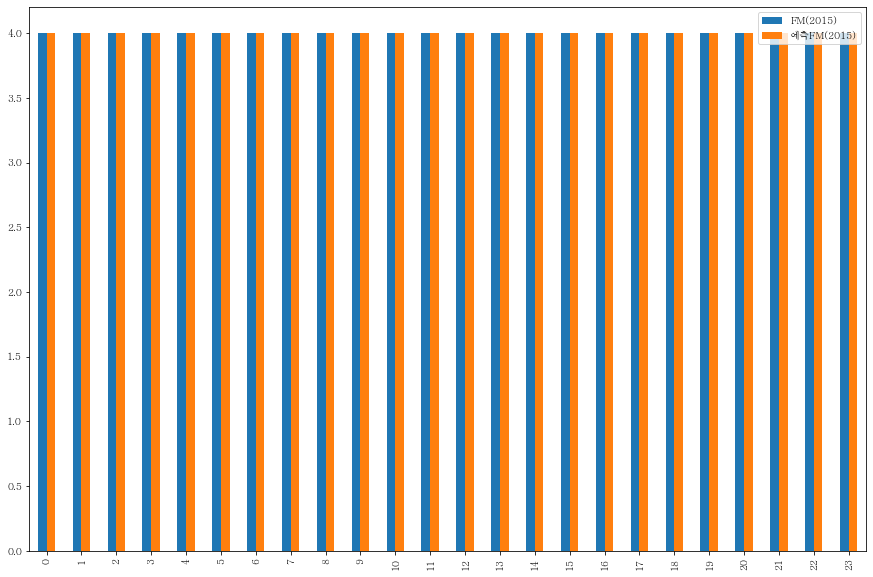

In [13]:
# mysql db 연동
db = pymysql.connect(host='127.0.0.1',password='gkftndlTek!!',user='root',db='tp',charset='utf8', 
    cursorclass=pymysql.cursors.DictCursor)

cursor = db.cursor()

query_2015 = "select FM, PU1, PU2, TE2, P1, P2 from wholeData where DATETIME between '2015-05-01 00:00:00' and '2015-08-31 23:00:00'"
cursor.execute(query_2015)
db_export_2015 = cursor.fetchall()

tp_2015=pd.DataFrame(db_export_2015)
#db_result_df = db_result_df.drop([db_result_df.columns[0]], axis=1) # 중복 index열 삭제

X=tp_2015[['FM', 'PU1', 'PU2', 'TE2','P1','P2']]
predict_2015_FM = lr.predict(X)
tp['예측FM(2015)'] = pd.Series(predict_2015_FM)
y_compare={'FM(2015)':tp_2015['FM'],'예측FM(2015)':tp['예측FM(2015)']}
y_compare=pd.DataFrame(y_compare)

y_compare_10 = y_compare.head(24)
mpl.rc('font', family='Batang')
y_compare_10.plot(y=['FM(2015)', '예측FM(2015)'], kind="bar")

In [14]:
tp_2015

,FM,PU1,PU2,TE2,P1,P2
0,4,0,0,19.8,3.6,3.7
1,4,0,0,19.8,3.6,3.7
2,4,0,0,19.8,3.6,3.6
3,4,0,0,19.8,3.6,3.6
4,4,0,0,19.8,3.6,3.6
...,...,...,...,...,...,...
2944,4,0,0,13.3,4.4,4.4
2945,4,0,0,14.0,4.8,4.8
2946,4,0,0,14.7,5.3,5.3
2947,4,0,0,15.3,5.7,5.7
